# ViVAE applied to cytometry data

Run this code to apply ViVAE to the Samusik bone marrow CyTOF dataset (DOI: [10.1038/nmeth.3863]((https://pubmed.ncbi.nlm.nih.gov/27183440/))) (from [HDCytoData](https://www.bioconductor.org/packages/release/data/experiment/html/HDCytoData.html)).

In [1]:
import numpy as np
import torch
import ViVAE

### CyTOF data import

We first import our input expression values and manually assigned cell labels.

In [2]:
dataset = 'Samusik'
exprs   = np.load(f'./cytometry_data/{dataset}_exprs.npy', allow_pickle=True)
labels  = np.load(f'./cytometry_data/{dataset}_annot.npy', allow_pickle=True)

### *k*-NN graph-based denoising

Create a k-nearest-neighbour graph (k-NNG) for denoising (pre-smoothing).

In [3]:
knn = ViVAE.make_knn(x=exprs, fname=f'./cytometry_data/{dataset}_knn.npy') # if knn already exists, it is loaded

Loading k-NNG


Denoise.
This increases local structure preservation.
The boundaries between populations in the resulting embedding become clearer and transitional cells are emedded along a more sharply defined skeleton.

In [4]:
exprs_d = ViVAE.smooth(exprs, knn, k=100, coef=1., n_iter=1)

### ViVAE dimension reduction

Set up a ViVAE model: parametric dimension-reduction model based on a regularised variational autoencoder (VAE).

In [5]:
model = ViVAE.ViVAE(input_dim=exprs.shape[1], latent_dim=2)

Generate the lower-dimensional (LD) embedding using three loss functions terms:

- **reconstruction error**: measures reconstruction of original data by decoder from LD representation sampled from the latent space

- **KL-divergence from latent prior**: divergence from isotropic Gaussian latent prior using reparametrisation (read more [here](https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important))

- **MDS (quartet) loss**: for joint optimisation of relative intra-quartet distances between repeatedly and randomly sampled points (see [SQuadMDS](https://dial.uclouvain.be/pr/boreal/object/boreal:264665) for original idea behind this); this gets a **weight of 10** (vs the other two errors)

Increase number of epochs (`n_epochs`) for better convergence or decrease it for shorter running times.

Increase batch size (`batch_size`) for faster training, decrease it for less memory usage.

Optimiser parameters (`learning_rate` and `weight_decay`) can be increased to speed up training, at the risk of instability and sub-optimal solutions.

In [6]:
np.random.seed(42)
torch.manual_seed(42)
model.fit(exprs_d, n_epochs=50)

Epoch 1/50	recon: 94.5904	kldiv: 12.6585	geom: 0.0000	egeom: 0.0000	mds: 156.3053
Epoch 2/50	recon: 19.7644	kldiv: 6.3109	geom: 0.0000	egeom: 0.0000	mds: 47.8701
Epoch 3/50	recon: 10.5750	kldiv: 4.1087	geom: 0.0000	egeom: 0.0000	mds: 31.2731
Epoch 4/50	recon: 7.1477	kldiv: 3.0767	geom: 0.0000	egeom: 0.0000	mds: 23.1540
Epoch 5/50	recon: 5.2909	kldiv: 2.4419	geom: 0.0000	egeom: 0.0000	mds: 18.2952
Epoch 6/50	recon: 4.1574	kldiv: 2.0272	geom: 0.0000	egeom: 0.0000	mds: 15.3558
Epoch 7/50	recon: 3.3947	kldiv: 1.7419	geom: 0.0000	egeom: 0.0000	mds: 13.0321
Epoch 8/50	recon: 2.8445	kldiv: 1.5232	geom: 0.0000	egeom: 0.0000	mds: 11.4758
Epoch 9/50	recon: 2.4512	kldiv: 1.3581	geom: 0.0000	egeom: 0.0000	mds: 10.2108
Epoch 10/50	recon: 2.1428	kldiv: 1.2191	geom: 0.0000	egeom: 0.0000	mds: 9.1453
Epoch 11/50	recon: 1.8797	kldiv: 1.1033	geom: 0.0000	egeom: 0.0000	mds: 8.2851
Epoch 12/50	recon: 1.6783	kldiv: 1.0189	geom: 0.0000	egeom: 0.0000	mds: 7.5719
Epoch 13/50	recon: 1.5011	kldiv: 0.9398	geom: 0

In [7]:
emb = model.transform(exprs_d)

### Plotting and optional denoising of embedding

Plot the 2-dimensional embedding, with labelled populations.
We specify an 'unassigned' population of ungated cells, which always gets plotted in grey and in the background.
Multiple such populations can be specified.

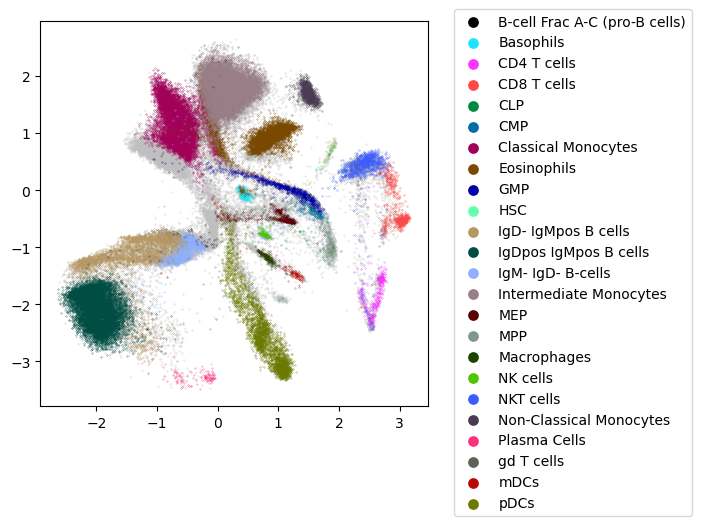

In [8]:
ViVAE.plot_embedding(emb, labels=labels, unassigned='unassigned')

If you want to see the underlying structure of this embedding more sharply, you can denoise the embedding further, using the original, high-dimensional k-NN relations (post-smoothing).

In [9]:
emb_d = ViVAE.smooth(emb, knn, k=100, coef=.1, n_iter=20)

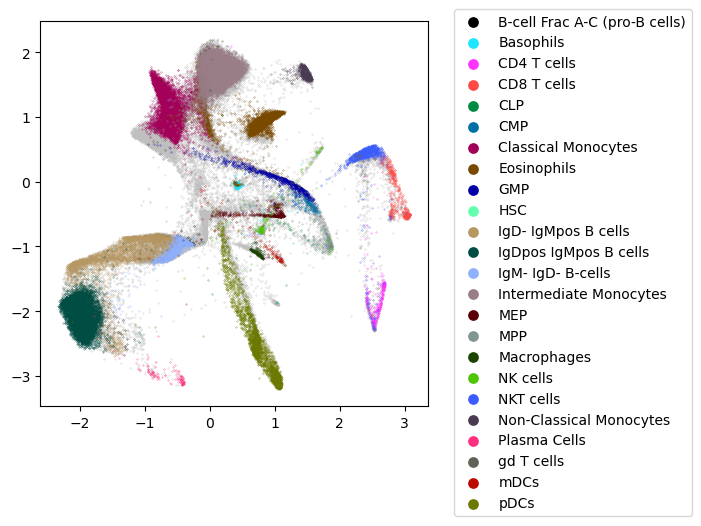

In [10]:
ViVAE.plot_embedding(emb_d, labels=labels, unassigned='unassigned')

### Encoder indicatrices

We can also compute and plot the encoder indicatrices, *ie.* objective indicators of local directed stretching of the data 2-manifold.
These are based on, but separate and different from, decoder indicatrices as implemented in *Geometric Autoencoders* (DOI: [arXiv:2306.17638](https://arxiv.org/abs/2306.17638)).

Indicatrices are small, equally large hyperspheres in the original, high-dimensional (HD) space (they lie in the [horizontal tangent space](https://gemini.google.com/share/9d567cee0c08) of existing data points).

As they are passed through the encoder, they can get distorted in two different ways.
Firstly, their size can vary across the embedding, including relative stretching or contraction of some parts of the points cloud.
Secondly, their shape can change (from sphere to ellipsis), which indicates the specific direction along which the distortion occurs.

In [11]:
ei_nice = model.encoder_indicatrices(X=exprs_d, radius=1e-3, n_steps=50, n_polygon=200)

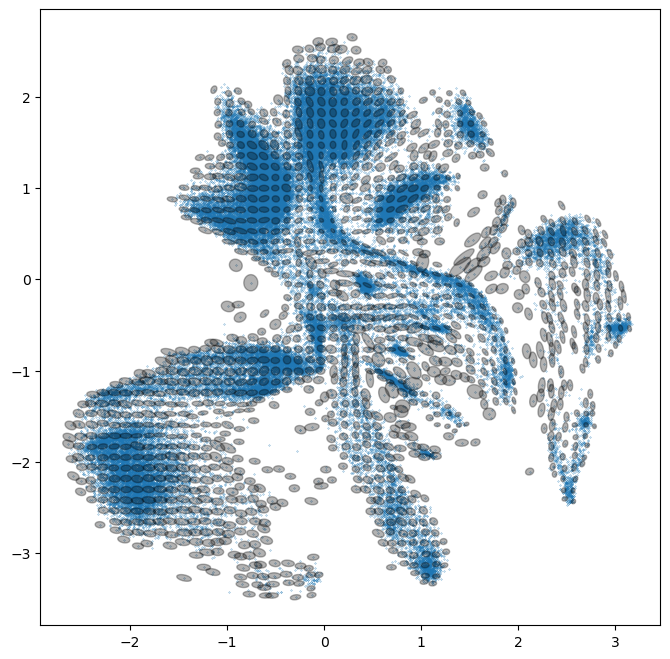

In [12]:
ViVAE.plot_indicatrices(indicatrices=ei_nice, scale_factor=8e1, figsize=(8,8))

The hyperspheres should have a small radius (`radius` in `model.encoder_indicatrices`), but not so small that the resulting shapes in the plot have sharp, as opposed to smooth, edges.

If the radius is set too large, the resulting plot may show a deformed elliptical, C-like or S-like shape in place of an ellipsis.

This is because the hyperspheres reach too far away from the data points and capture deformation outside the horizontal tangent space.
Such a visualisation is typically less informative.

In [13]:
ei_large = model.encoder_indicatrices(X=exprs_d, radius=1e2, n_steps=50, n_polygon=200)

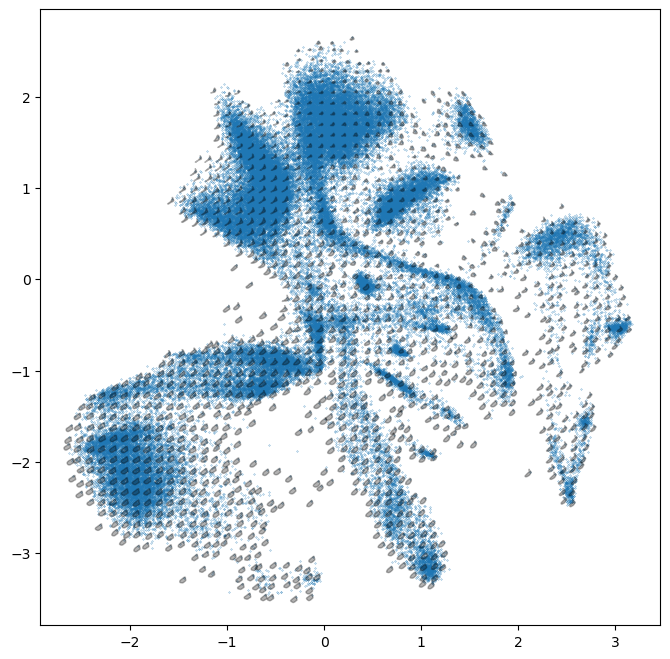

In [14]:
ViVAE.plot_indicatrices(indicatrices=ei_large, scale_factor=3e-3, figsize=(8,8))

If the radius is set too small, the edges of the hyperspheres will appear sharp, as opposed to smooth.

In [15]:
ei_small = model.encoder_indicatrices(X=exprs_d, radius=1e-6, n_steps=50, n_polygon=200)

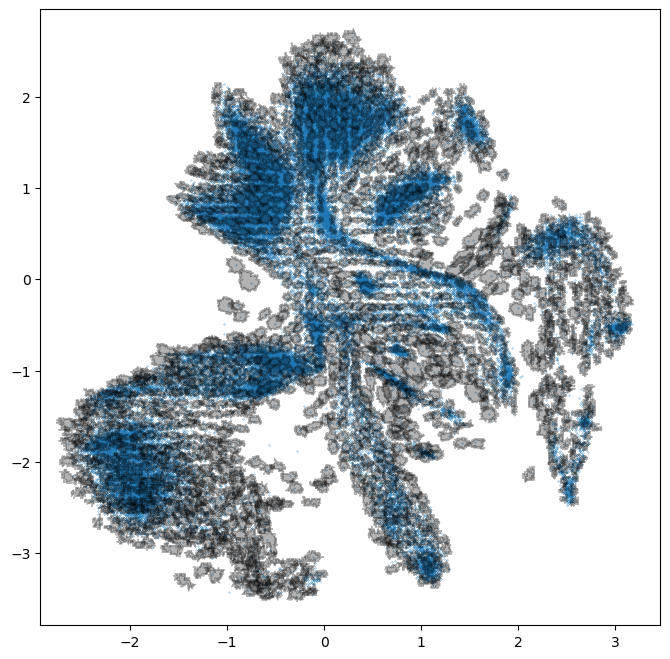

In [16]:
ViVAE.plot_indicatrices(indicatrices=ei_small, scale_factor=1e5, figsize=(8,8))

Note that the `scale_factor` in `plot_indicatrices` needs to be adapted for a good plot (*ie.* indicatrices should be plotted large enough to be informative, but small enough to not have too much overlap).

These are some additional arguments you can alter:

- `n_steps` in `encoder_indicatrices` determines the density of indicatrices (which are sampled on a grid). Higher values will ensure better coverage of the space, but cause a more cluttered plot.

- `n_polygon` in `encoder_indicatrices` determined how many points per indicatrix are sampled. Higher values will ensure higher-quality graphical output, but may increase running time if extremely high.

Note that encoder indicatrices can be implemented for any encoder (*ie.* differentiable dimension-reducing models).

<hr>

For both unsupervised and supervised evaluation of LD embeddings, use [*ViScore*](https://github.com/saeyslab/ViScore).